In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# Carregar o arquivo CSV
file_path = 'train.csv'  # Caminho do arquivo
data = pd.read_csv(file_path)

In [ ]:
# Pré-processamento
data['Date'] = pd.to_datetime(data['Date'])  # Converter a coluna Date para datetime
data['Year'] = data['Date'].dt.year         # Adicionar coluna de ano
data['Month'] = data['Date'].dt.month       # Adicionar coluna de mês
data['Day'] = data['Date'].dt.day           # Adicionar coluna de dia


In [ ]:
# Ordenar os dados por departamento e data
data = data.sort_values(by=['Dept', 'Year', 'Month', 'Day'])

# Criar features baseadas em vendas passadas
data['Prev_Week_Sales'] = data.groupby('Dept')['Weekly_Sales'].shift(1)
data['MA_2_Weeks'] = data.groupby('Dept')['Weekly_Sales'].shift(1).rolling(window=2).mean()
data['MA_4_Weeks'] = data.groupby('Dept')['Weekly_Sales'].shift(1).rolling(window=4).mean()



In [ ]:
# Remover as linhas iniciais que ficaram com NaN
data = data.dropna()

# Converter 'IsHoliday' em dummies
data = pd.get_dummies(data, columns=['IsHoliday'], drop_first=True)

# Separar treino (dados até 2011) e teste (dados de 2012)
train_data = data[data['Year'] < 2012]
test_data = data[data['Year'] == 2012]


In [ ]:
# Separar features e alvo
features = ['Store', 'Dept', 'IsHoliday_True', 'Prev_Week_Sales', 'MA_2_Weeks', 'MA_4_Weeks']
X_train = train_data[features]
y_train = train_data['Weekly_Sales']
X_test = test_data[features]
y_test = test_data['Weekly_Sales']

In [ ]:
# Treinar o modelo Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_gbr = gbr_model.predict(X_test)

In [ ]:
# Avaliar o modelo
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
print(f"Erro Médio Quadrático Raiz (RMSE): {rmse_gbr:.2f}")

# Adicionar previsões ao conjunto de teste para análise
test_results_gbr = test_data.copy()
test_results_gbr['Predicted_Weekly_Sales'] = y_pred_gbr

Erro Médio Quadrático Raiz (RMSE): 10781.99


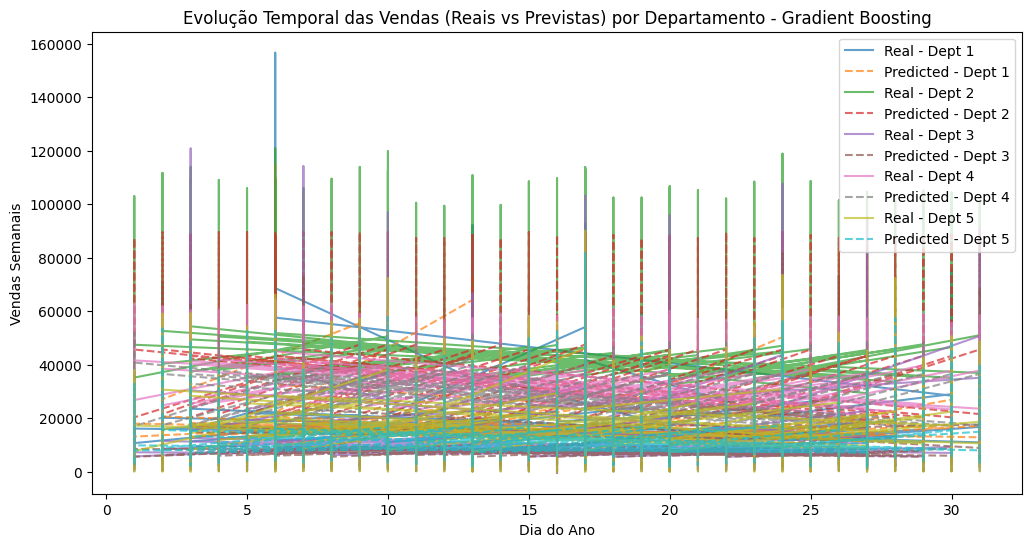

In [ ]:
# Gráficos
# Gráfico 1: Evolução temporal das vendas (Reais vs Previstas) com Gradient Boosting
test_results_gbr_sorted = test_results_gbr.sort_values(by=['Dept', 'Year', 'Month', 'Day'])

plt.figure(figsize=(12, 6))
for dept in test_results_gbr_sorted['Dept'].unique()[:5]:  # Visualizar os 5 primeiros departamentos
    dept_data = test_results_gbr_sorted[test_results_gbr_sorted['Dept'] == dept]
    plt.plot(dept_data['Day'], dept_data['Weekly_Sales'], label=f'Real - Dept {dept}', alpha=0.7)
    plt.plot(dept_data['Day'], dept_data['Predicted_Weekly_Sales'], linestyle='--', label=f'Predicted - Dept {dept}', alpha=0.7)

plt.title("Evolução Temporal das Vendas (Reais vs Previstas) por Departamento - Gradient Boosting")
plt.xlabel("Dia do Ano")
plt.ylabel("Vendas Semanais")
plt.legend()
plt.show()

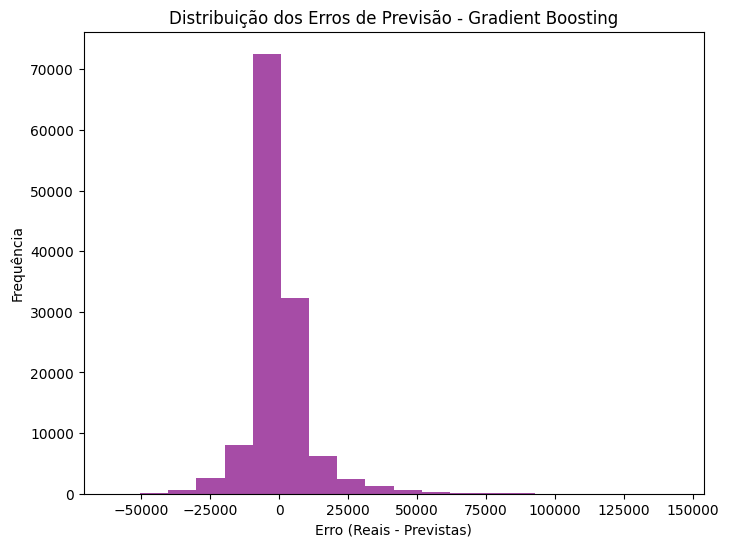

In [ ]:
# Gráfico 2: Distribuição dos erros (Reais - Previstas) - Gradient Boosting
errors_gbr = test_results_gbr['Weekly_Sales'] - test_results_gbr['Predicted_Weekly_Sales']
plt.figure(figsize=(8, 6))
plt.hist(errors_gbr, bins=20, alpha=0.7, color='purple')
plt.title("Distribuição dos Erros de Previsão - Gradient Boosting")
plt.xlabel("Erro (Reais - Previstas)")
plt.ylabel("Frequência")
plt.show()

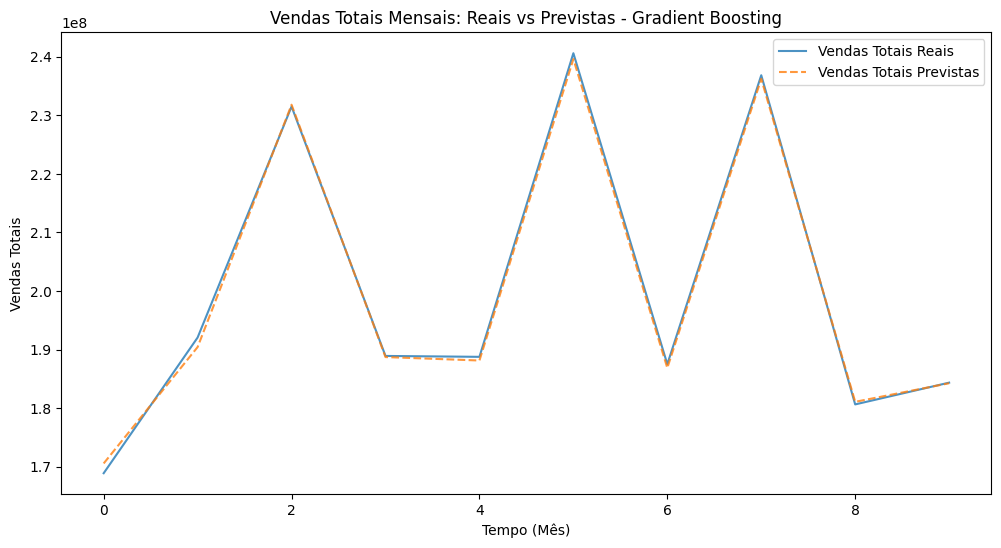

In [ ]:
# Gráfico 3: Vendas Totais Reais vs Previstas ao longo do tempo - Gradient Boosting
totals_over_time_gbr = test_results_gbr.groupby(['Year', 'Month']).agg({
    'Weekly_Sales': 'sum',
    'Predicted_Weekly_Sales': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(totals_over_time_gbr.index, totals_over_time_gbr['Weekly_Sales'], label='Vendas Totais Reais', alpha=0.8)
plt.plot(totals_over_time_gbr.index, totals_over_time_gbr['Predicted_Weekly_Sales'], linestyle='--', label='Vendas Totais Previstas', alpha=0.8)
plt.title("Vendas Totais Mensais: Reais vs Previstas - Gradient Boosting")
plt.xlabel("Tempo (Mês)")
plt.ylabel("Vendas Totais")
plt.legend()
plt.show()

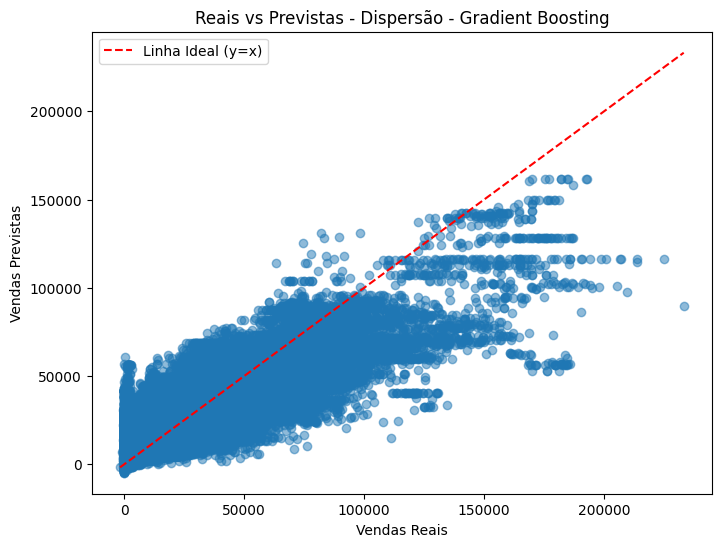

In [ ]:
# Gráfico 4: Scatter Plot - Reais vs Previstas - Gradient Boosting
plt.figure(figsize=(8, 6))
plt.scatter(test_results_gbr['Weekly_Sales'], test_results_gbr['Predicted_Weekly_Sales'], alpha=0.5)
plt.plot([test_results_gbr['Weekly_Sales'].min(), test_results_gbr['Weekly_Sales'].max()],
         [test_results_gbr['Weekly_Sales'].min(), test_results_gbr['Weekly_Sales'].max()],
         color='red', linestyle='--', label='Linha Ideal (y=x)')
plt.title("Reais vs Previstas - Dispersão - Gradient Boosting")
plt.xlabel("Vendas Reais")
plt.ylabel("Vendas Previstas")
plt.legend()
plt.show()